<a href="https://colab.research.google.com/github/bennettJG/data17200project/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Load your data, including testing/training split from Project 1

In [190]:
# Load preprocessed data from part 1

import zipfile, io, pickle
from urllib.request import urlopen

# Suppress non-convergence warnings from LogisticRegression for readability
import warnings
warnings.filterwarnings("ignore")

r = urlopen("https://github.com/bennettJG/data17200project/raw/refs/heads/main/preprocessed_data.zip")
#print(r)
z = zipfile.ZipFile(io.BytesIO(r.read()))
z.extractall()

with open("preprocessed_data.pkl", "rb") as input_file:
  X_train_scaled, X_test_scaled, y_train, y_test = pickle.load(input_file)

groups_train = X_train_scaled['patient_nbr']

# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GroupShuffleSplit, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph, NearestNeighbors, radius_neighbors_graph
from sklearn.preprocessing import StandardScaler

random_state=1701

This data set is large (around 80,000 observations in the training set), and both the agglomerative clustering and DBSCAN algorithms require the calculation of a distance matrix for the full data set (that is, the distances between every pair of observations). This requires memory proportional to the square of the number of observations, which exceeds the capacity available in Google Colab in this case.

I attempted to mitigate this by using connectivity constraints for hierarchical clustering (see e.g. https://datafiction.github.io/docs/ml/Clustering/Agglomerative/Agglomerative/#4-hierarchical-clustering-structured-vs-unstructured-ward) and pre-calculating neighborhoods to pass a sparse matrix to `DBSCAN` (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), as well as specifying the more memory-efficient 'ball_tree' algorithm for distance calculations. However, this continued to be very slow and memory-intensive, which was a particular problem for DBSCAN since identifying appropriate values for `eps` and `min_samples` requires running the algorithm repeatedly.

To experiment with clustering techniques without running into computational constraints, I ultimately chose to take a stratified sample of half the patients in the training set and run clustering on this subset of the data.

In [191]:
# This code is very slow and the DBSCAN part may crash Colab due to memory limits.
# I'm preserving it here, commented out, to show what I tried, but wouldn't recommend running it.

# This takes a few minutes to run
# Specify connectivity constraints and fit agglomerative clustering
# connectivity = kneighbors_graph(X_train_scaled, n_neighbors=50, include_self=False)
# Agg4 = AgglomerativeClustering(n_clusters=4, connectivity=connectivity).fit_predict(X_train_scaled)

# Pre-compute distances for DBSCAN
# nn = NearestNeighbors(radius=4, algorithm='ball_tree', leaf_size=200).fit(X_train_scaled)
# neighbors = nn.radius_neighbors_graph(X_train_scaled, mode='distance')

# Fit DBSCAN to precomputed sparse distances matrix
# db = DBSCAN(eps=3, min_samples=200, metric='precomputed').fit(neighbors)
# labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
#print("Estimated number of noise points: %d" % n_noise_)

In [192]:
keep_index, drop_index = next(
    GroupShuffleSplit(n_splits = 1, test_size = 0.5, random_state=1701).split(X_train_scaled, groups=groups_train)
)

X_train_small = X_train_scaled.loc[keep_index].drop('patient_nbr', axis=1)
y_train_small= y_train.reset_index().loc[keep_index]

X_train_scaled = X_train_scaled.drop('patient_nbr', axis=1)
X_test_scaled = X_test_scaled.drop('patient_nbr', axis=1)

print(X_train_small.shape)

(39439, 106)


I also opted to drop most of the one-hot encoded variables, which did not have high correlations with the target value. For each variable dropped, I re-ran the best-fitting model with it omitted to confirm that performance did not meaningfully decrease (that is, that the features were not predictive of the target).

In [193]:
drop_cols = X_train_scaled.columns[X_train_scaled.columns.str.match('gender|repaglinide|glyburide|glipizide|glimepiride|pioglitazone|rosiglitazone|payer_code_|admission_type|broad_category|race_|max_glu_serum|diabetes|A1Cresult|change|admission_source')]
X_train_small = X_train_small.drop(drop_cols, axis=1)
X_test_small = X_test_scaled.drop(drop_cols, axis=1)

In [194]:
# Test metrics helper function from Project 2
from sklearn.metrics import make_scorer

def calculate_test_metrics(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f'Classification report:\n')
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# 2. PCA for feature selection

To reach 95% variance explained for all features, 13 principal components are needed. However, the contribution of most of these features is quite small -- a single feature (most strongly associated with time spent in the hospital during previous encounters) explains 64% of variance, while components 1-8 (most strongly associated with combinations of the other numeric features) collectively explain around 25%. The remaining principal components are each associated with one of the categorical features, and individually explain very little variance.

[0.63739512 0.7051808  0.75558064 0.79164041 0.82333346 0.84796593
 0.87026822 0.88991115 0.90644855 0.92138475 0.93434716 0.9471362
 0.95805734]


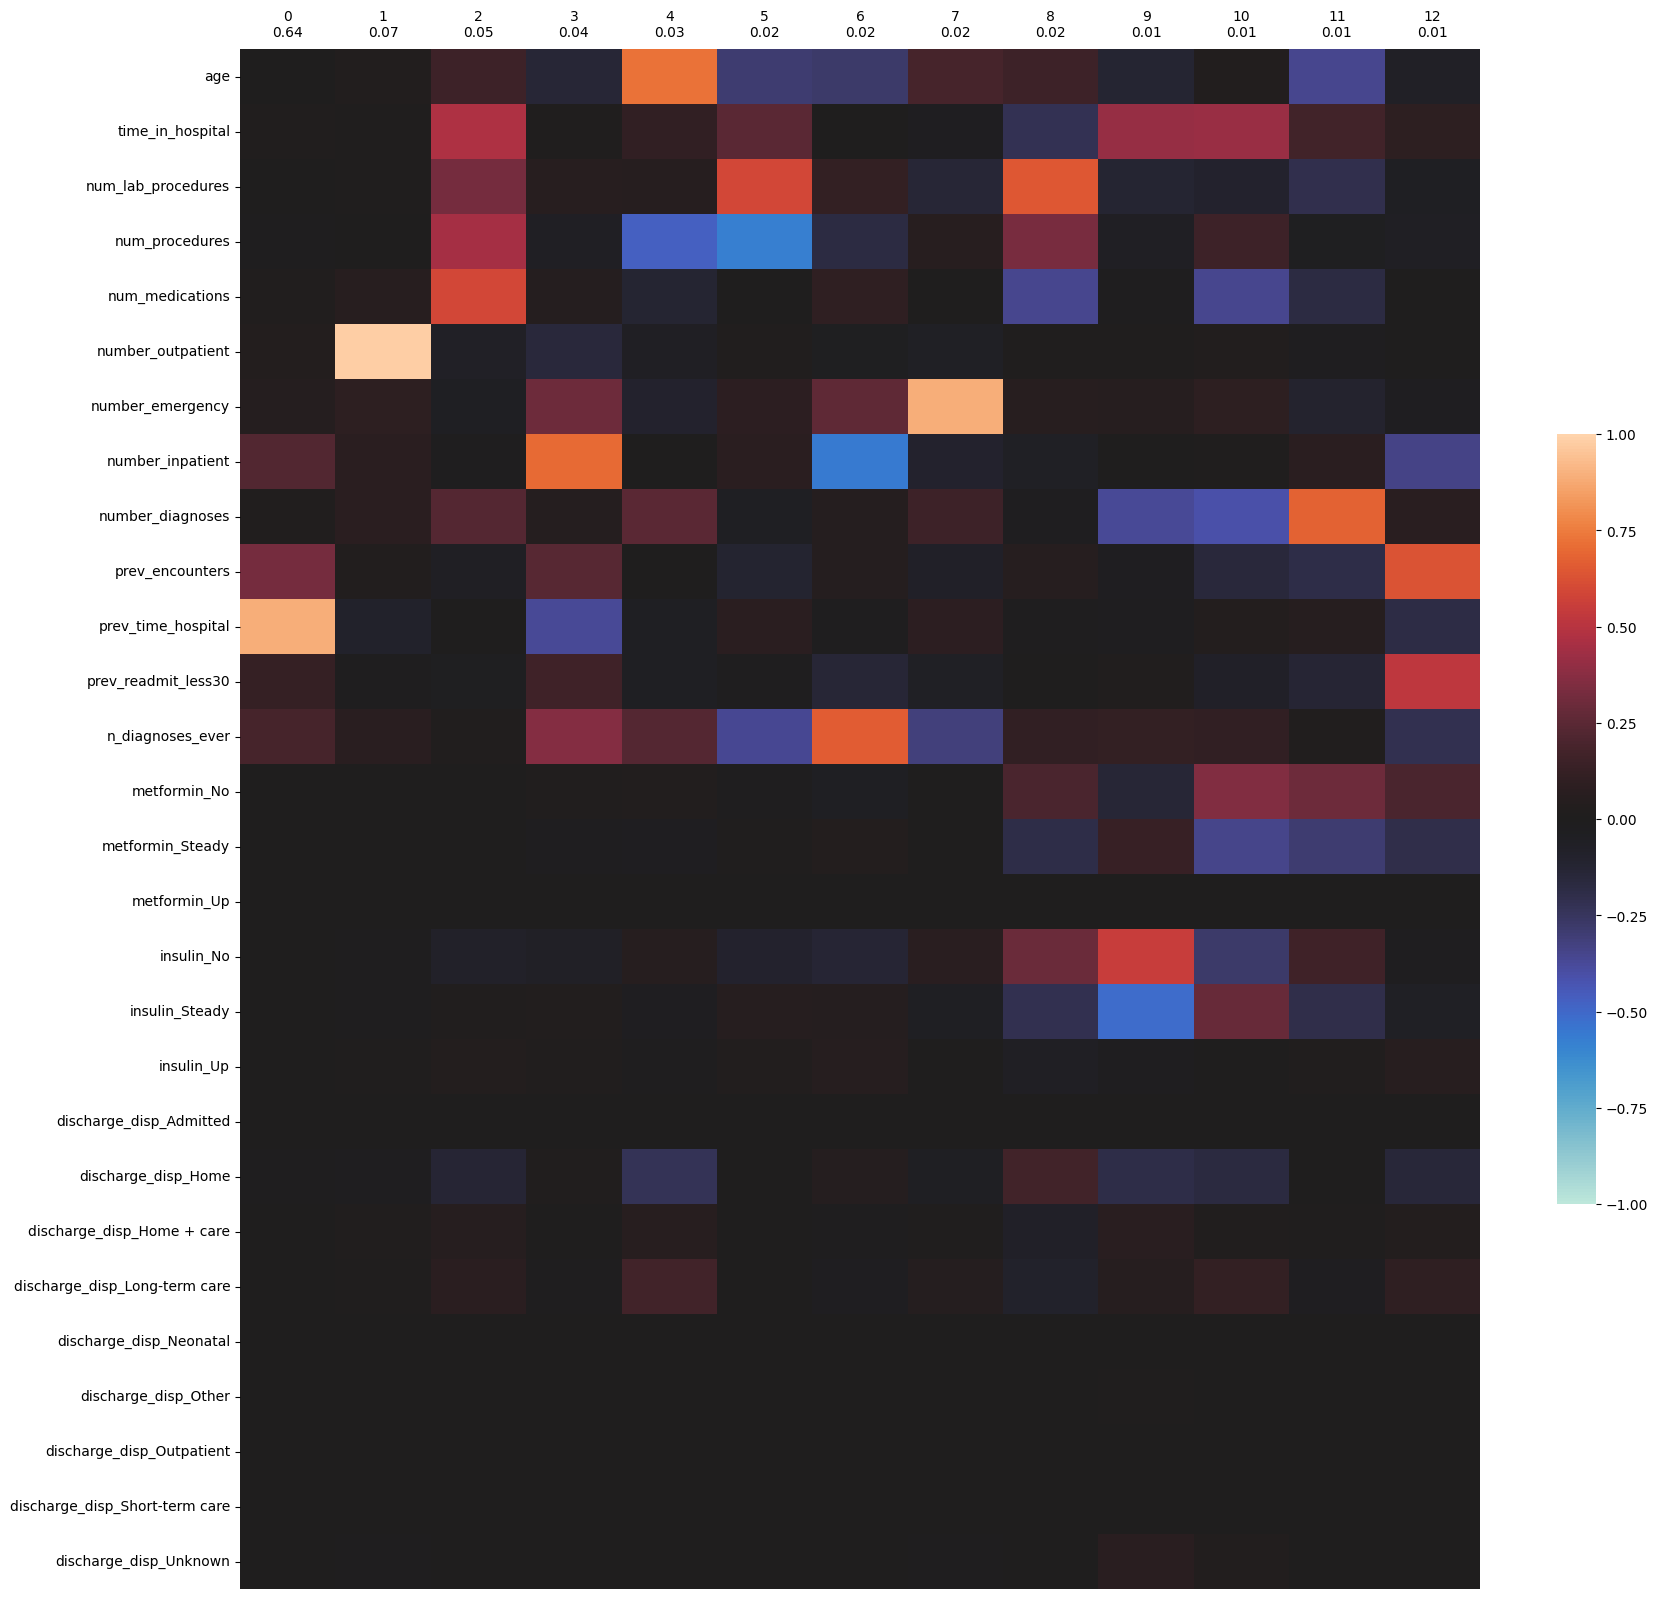

In [195]:
# PCA explaining 95% of variance in features
pca = PCA(n_components=0.95)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_small))
X_test_pca = pca.transform(X_test_small)
print(pca.explained_variance_ratio_.cumsum())

# Plot heatmap of principal component weightings
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(pca.components_.T, cmap='icefire', vmin=-1, vmax=1, cbar_kws={"shrink": 0.5},
            yticklabels=X_train_small.columns.str.slice(0,40))
ax.set_xticklabels(np.arange(len(pca.explained_variance_ratio_)).astype(str) + "\n" + pca.explained_variance_ratio_.round(2).astype(str), rotation=0)
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

The best-performing model from earlier supervised learning (on the binary classification task of detecting patients who will be readmitted within 30 days) was Random Forest with `n_estimators`=50 and `max_depth`=6. The performance for this model training on the full training set was:

Classification report:

              precision    recall  f1-score   support

       False       0.96      0.59      0.73     18104
        True       0.20      0.80      0.32      2298

    accuracy                           0.61     20402
   macro avg       0.58      0.69      0.52     20402
weighted avg       0.87      0.61      0.68     20402



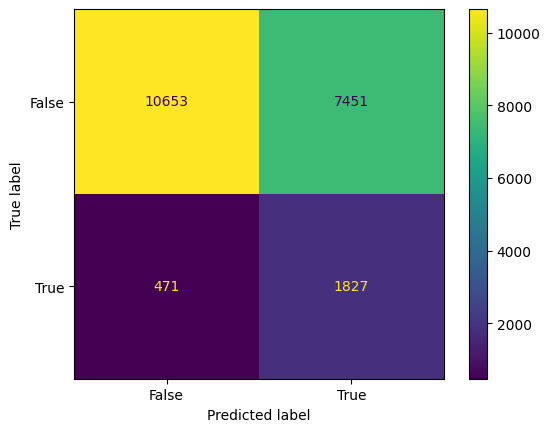

In [196]:
rf_model = RandomForestClassifier(random_state=random_state, class_weight='balanced_subsample', max_depth=6, n_estimators=50)
calculate_test_metrics(rf_model, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

Training on the reduced training set and testing on the full test set, somewhat surprisingly, results in near-identical performance -- in fact, the recall for the class we care most about is slightly *higher* (0.82 rather than 0.80).

Classification report:

              precision    recall  f1-score   support

       False       0.96      0.59      0.73     18104
        True       0.20      0.82      0.32      2298

    accuracy                           0.61     20402
   macro avg       0.58      0.70      0.52     20402
weighted avg       0.88      0.61      0.68     20402



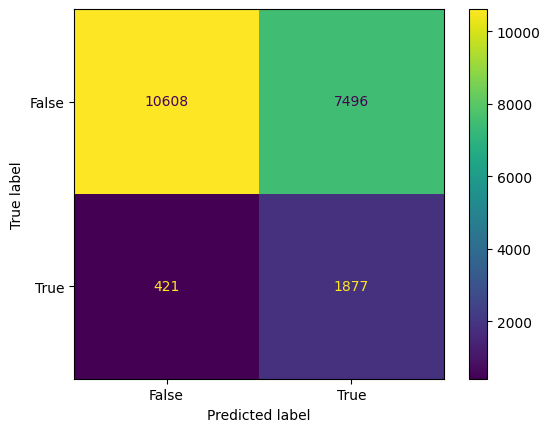

In [197]:
calculate_test_metrics(rf_model, X_train_small, X_test_small, y_train_small['readmit_less30'], y_test['readmit_less30'])

Fitting this model on the PCA-transformed data gives comparable recall on our class of interest, readmission within 30 days (0.80) but somewhat worse on the negative class. A small drop in performance is to be expected since the principal components do not capture 100% of variance in the data, but this false-positive rate would be unacceptable in most settings.

Classification report:

              precision    recall  f1-score   support

       False       0.96      0.56      0.71     18104
        True       0.19      0.80      0.31      2298

    accuracy                           0.59     20402
   macro avg       0.57      0.68      0.51     20402
weighted avg       0.87      0.59      0.66     20402



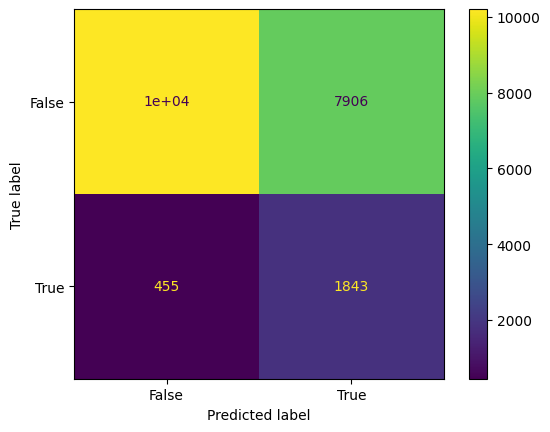

In [198]:
calculate_test_metrics(rf_model, X_train_pca, X_test_pca, y_train_small['readmit_less30'], y_test['readmit_less30'])

# 3: Apply three types of clustering (K-means, agglomerate or hierarchical, DBSCAN) and visualize the output both with and without PCA. Calculate ARI and silhouette coefficient for all six of the combinations.

In [199]:
# Elbow plot code taken from lecture notebook
def plot_elbow(X_train, max_k):
  inertiaVals = {}

  for k in range(1, max_k+1):
      kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train)
      inertiaVals[k] = kmeansTmp.inertia_
  plt.figure()
  plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
  plt.xlabel("Number of clusters")
  plt.ylabel("Inertia")
  plt.title("K-Means Elbow Plot")
  plt.show()

## Clustering on Original Data

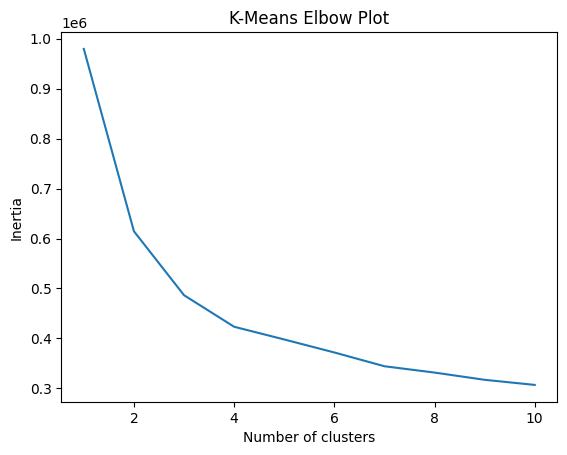

In [200]:
plot_elbow(X_train_small, 10)

The location of the plot's "elbow" suggests that four clusters would be appropriate, even though the classification target has only three classes (and we have primarily focused on distinguishing one of those classes from the other two). If four clusters are used the ARI is guaranteed to be low, since even if (for example) the first cluster contained all patients readmitted in less than 30 days and the other three contained all patients not readmitted within 30 days, the metric penalizes unnecessary splits. In addition to the four-cluster grouping, I will test comparisons of 3 clusters with the three target classes, and two clusters with the binary classification.

In [201]:
KMeans4 = KMeans(n_clusters=4).fit_predict(X_train_small)
KMeans3 = KMeans(n_clusters=3).fit_predict(X_train_small)
KMeans2 = KMeans(n_clusters=2).fit_predict(X_train_small)

In [202]:
# Adapted from lecture code
# Passing predictions rather than algorithms since many of the algorithms are slow and I'd rather run them one at a time to troubleshoot memory issues
def plot_ARI(X, y, predictions, feature1, feature2):
  nclass = len(pd.unique(y))
  fig, axes = plt.subplots(1, len(predictions) + 2, figsize=(20, 4),
                          subplot_kw={'xticks': (), 'yticks': ()})
  # create a random cluster assignment for reference
  random_gen = np.random.RandomState(random_state)
  random_clusters = random_gen.randint(low=0, high=nclass, size=len(X))

  # plot random assignment
  axes[0].scatter(X.loc[:, feature1], X.loc[:, feature2], c=pd.Categorical(y).codes,
                  s=10)
  axes[0].set_title("True values")
  axes[0].set_xlabel(feature1)
  axes[0].set_ylabel(feature2)

  axes[1].scatter(X.loc[:, feature1], X.loc[:, feature2], c=random_clusters,
                  s=10)
  axes[1].set_title("Random assignment - ARI: {:.2f},\nSilhouette Score: {:.2f}".format(
          adjusted_rand_score(y, random_clusters),
          silhouette_score(X, random_clusters)))
  axes[1].set_xlabel(feature1)
  axes[1].set_ylabel(feature2)

  for ax, pred in zip(axes[2:], predictions):
      # plot the cluster assignments and cluster centers
      clusters = pred['clusters']
      print("{} - clustering vs. target labels".format(pred['alg']))
      print(pd.crosstab(clusters, y))
      ax.scatter(X.loc[:, feature1], X.loc[:, feature2], c=clusters,
                s=10)
      ax.set_title("{} - ARI: {:.2f},\nSilhouette Score: {:.2f}".format(pred['alg'],
                                            adjusted_rand_score(y, clusters),
                                            silhouette_score(X, clusters)))
      ax.set_xlabel(feature1)
      ax.set_ylabel(feature2)

In [203]:
# Specify connectivity constraints and fit agglomerative clustering
connectivity = kneighbors_graph(X_train_small, n_neighbors=50, include_self=False)
Agg4 = AgglomerativeClustering(n_clusters=4, connectivity=connectivity).fit_predict(X_train_small)

In [204]:
Agg3 = AgglomerativeClustering(n_clusters=3, connectivity=connectivity).fit_predict(X_train_small)
Agg2 = AgglomerativeClustering(n_clusters=2, connectivity=connectivity).fit_predict(X_train_small)

For DBSCAN, the number of clusters cannot be specified explicitly -- rather, observations are classified to one of several clusters or as "noise" based on their distances. The maximum distance allowed for points to be considered "in the same neighborhood" (and thus added to a cluster) is specified as `eps` and the minimum number of observations for a cluster to not be considered noise is specified as `min_samples`. Adjusting the values of these hyperparameters will affect the clusters produced (generally, higher `eps` and lower `min_samples` will increase the number of clusters). Experimentation is required to identify the most appropriate values for a given data set.

Unfortunately, even after extensive trial and error (which is still very slow even with the reduced data set), there was no DBSCAN solution which grouped observations into one of several equally-sized groups. The large majority of observations were consistently treated as one group, with additional groups (when present) containing only a handful of observations each. One such clustering is presented as an example, but this method would not be appropriate for this dataset.

In [205]:
# Specify ball_tree algorithm for lower memory usage
# This is still quite slow unfortunately!
DB = DBSCAN(eps=2, min_samples=5, algorithm='ball_tree').fit_predict(X_train_small)

`n_diagnoses_ever` and `number_inpatient` were the two features with the highest feature importance in the RF model, so for visualization I plotted the data against these features.

KMeans (4 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0                1219    356
1                5302   1120
2                  87     60
3               28419   2876
Agglomerative (4 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0                7951   1485
1                 128     90
2               25911   2540
3                1037    297
DBSCAN - clustering vs. target labels
readmit_less30  False  True 
row_0                       
-1               3688   1056
 0              31277   3345
 1                 39      9
 2                 11      1
 3                  5      0
 4                  4      1
 5                  3      0


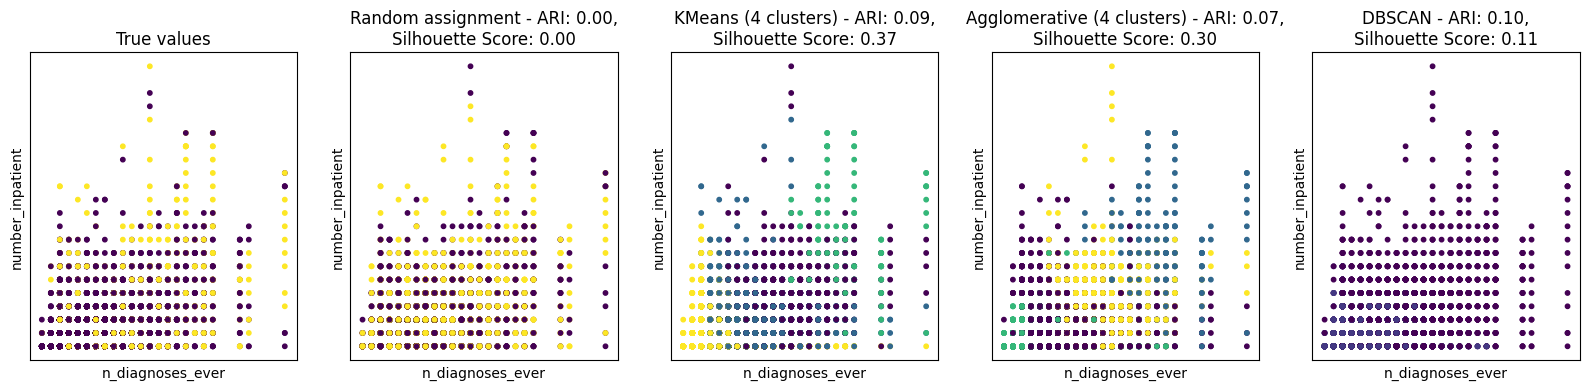

In [206]:
predictions = [{'alg': 'KMeans (4 clusters)', 'clusters':KMeans4}, {'alg':'Agglomerative (4 clusters)', 'clusters':Agg4}, {'alg':'DBSCAN', 'clusters':DB}]
plot_ARI(X_train_small, y_train_small['readmit_less30'], predictions, 'n_diagnoses_ever', 'number_inpatient')

KMeans (3 clusters) - clustering vs. target labels
readmitted   <30    >30     NO
row_0                         
0            135    180     81
1           3333  11405  19309
2            944   2444   1608
Agglomerative (3 clusters) - clustering vs. target labels
readmitted   <30   >30     NO
row_0                        
0            387   770    395
1           1485  4245   3706
2           2540  9014  16897
DBSCAN - clustering vs. target labels
readmitted   <30    >30     NO
row_0                         
-1          1056   2386   1302
 0          3345  11607  19670
 1             9     23     16
 2             1      8      3
 3             0      1      4
 4             1      3      1
 5             0      1      2


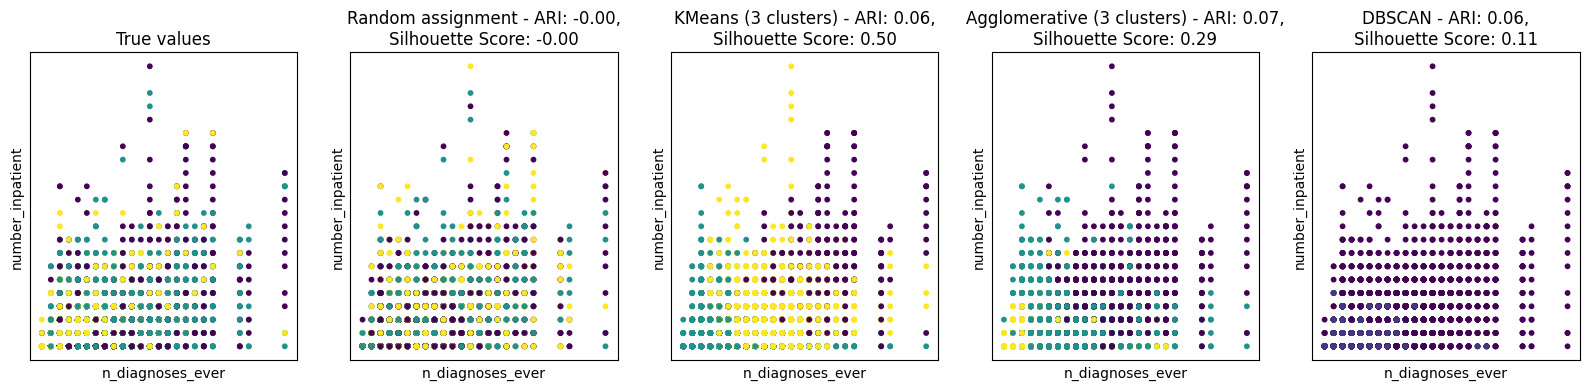

In [207]:
predictions = [{'alg': 'KMeans (3 clusters)', 'clusters':KMeans3}, {'alg':'Agglomerative (3 clusters)', 'clusters':Agg3}, {'alg':'DBSCAN', 'clusters':DB}]
plot_ARI(X_train_small, y_train_small['readmitted'], predictions, 'n_diagnoses_ever', 'number_inpatient')

KMeans (2 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0               32810   3749
1                2217    663
Agglomerative (2 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0               33862   4025
1                1165    387
DBSCAN - clustering vs. target labels
readmit_less30  False  True 
row_0                       
-1               3688   1056
 0              31277   3345
 1                 39      9
 2                 11      1
 3                  5      0
 4                  4      1
 5                  3      0


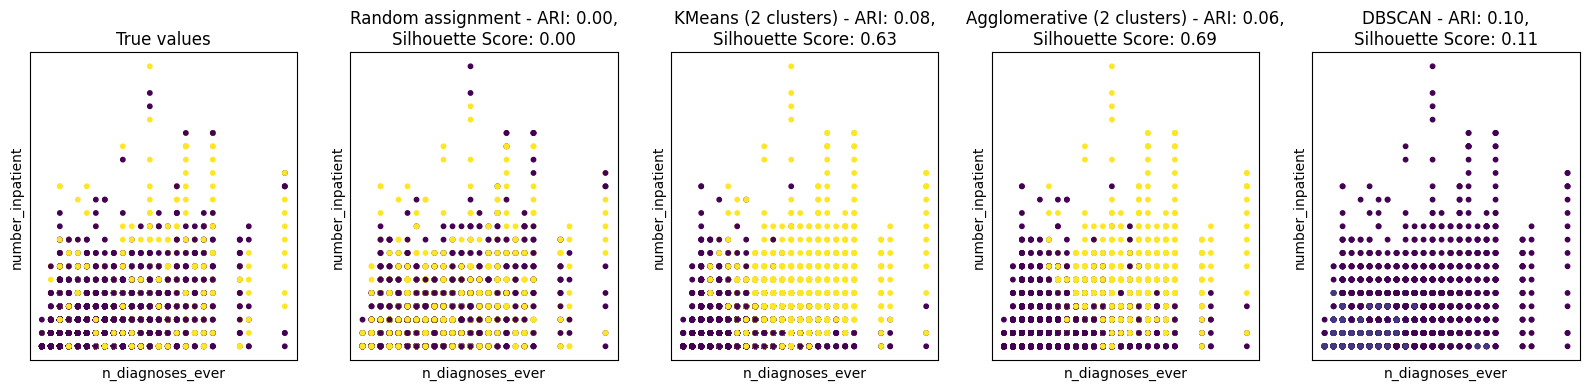

In [208]:
predictions = [{'alg': 'KMeans (2 clusters)', 'clusters':KMeans2}, {'alg':'Agglomerative (2 clusters)', 'clusters':Agg2}, {'alg':'DBSCAN', 'clusters':DB}]
plot_ARI(X_train_small, y_train_small['readmit_less30'], predictions, 'n_diagnoses_ever', 'number_inpatient')

As we can see from the ARI scores, these clusterings are virtually useless for classification -- they do not distinguish well between the target categories. However, the silhouette scores indicate that they *do* distinguish patients based on their characteristics (we can see this in the plots as well). It is just that the predictive rules identified by the random forest algorithm do not correspond to distance-based clusters. That is, there is not a clear "profile" of patients who are or are not readmitted within 30 days. We can see this in the plots as well -- even though the two highest-importance features were plotted, there is considerable overlap between patients who were and were not readmitted.

## Clustering on PCA-transformed Data

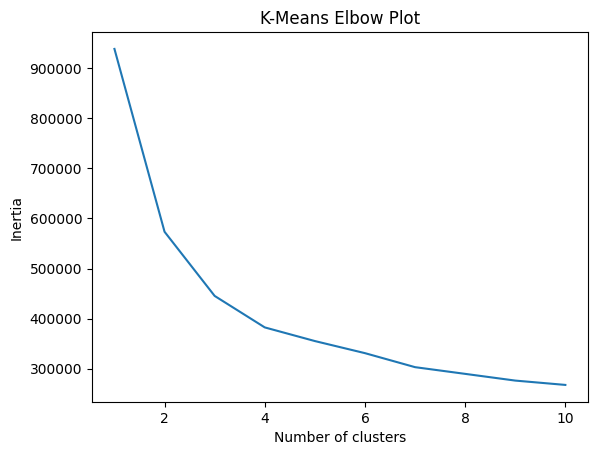

In [209]:
plot_elbow(X_train_pca, 10)

Here as well, the "elbow" appears to be around 4 clusters.

In [210]:
# Fit K-means and agglomerative clustering
KMeans4_pca = KMeans(n_clusters=4).fit_predict(X_train_pca)
KMeans3_pca = KMeans(n_clusters=3).fit_predict(X_train_pca)
KMeans2_pca = KMeans(n_clusters=2).fit_predict(X_train_pca)
connectivity_pca = kneighbors_graph(X_train_pca, n_neighbors=50, include_self=False)
Agg4_pca = AgglomerativeClustering(n_clusters=4, connectivity=connectivity_pca).fit_predict(X_train_pca)
Agg3_pca = AgglomerativeClustering(n_clusters=3, connectivity=connectivity_pca).fit_predict(X_train_pca)
Agg2_pca = AgglomerativeClustering(n_clusters=2, connectivity=connectivity_pca).fit_predict(X_train_pca)

As in the full-data case, DBSCAN produced uninformative "clusters" (with nearly all observations in the same cluster) across values of `eps` and `min_samples`. One sample combination is shown as an example.

In [211]:
db_pca = DBSCAN(eps=2, min_samples=5, algorithm='ball_tree').fit_predict(X_train_pca)

For the PCA supervised learning model, principal components 0 and 3 had the highest feature importance and were chosen for data visualization.

KMeans (4 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0               28404   2873
1                  88     61
2                1224    357
3                5311   1121
Agglomerative (4 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0                4759    910
1                1771    509
2                  82     57
3               28415   2936
DBSCAN - clustering vs. target labels
readmit_less30  False  True 
row_0                       
-1               1632    554
 0              33370   3855
 1                  9      0
 2                 11      3
 3                  5      0


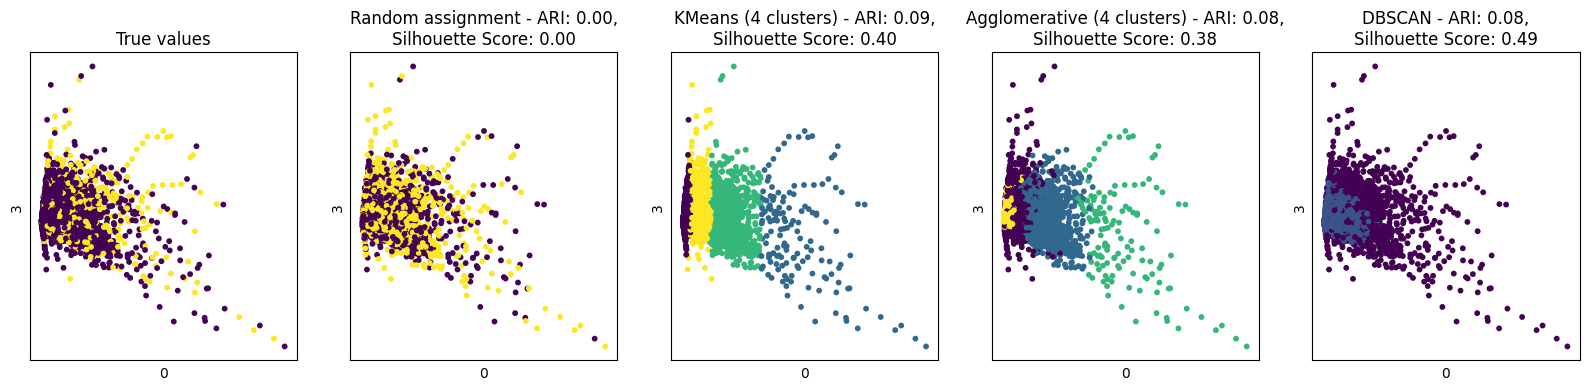

In [212]:
predictions = [{'alg': 'KMeans (4 clusters)', 'clusters':KMeans4_pca}, {'alg':'Agglomerative (4 clusters)', 'clusters':Agg4_pca}, {'alg':'DBSCAN', 'clusters':db_pca}]
plot_ARI(X_train_pca, y_train_small['readmit_less30'], predictions, 0, 3)

KMeans (3 clusters) - clustering vs. target labels
readmitted   <30    >30     NO
row_0                         
0            917   2353   1520
1           3380  11534  19418
2            115    142     60
Agglomerative (3 clusters) - clustering vs. target labels
readmitted   <30    >30     NO
row_0                         
0           3846  12841  20333
1            509   1122    649
2             57     66     16
DBSCAN - clustering vs. target labels
readmitted   <30    >30     NO
row_0                         
-1           554   1130    502
 0          3855  12885  20485
 1             0      5      4
 2             3      8      3
 3             0      1      4


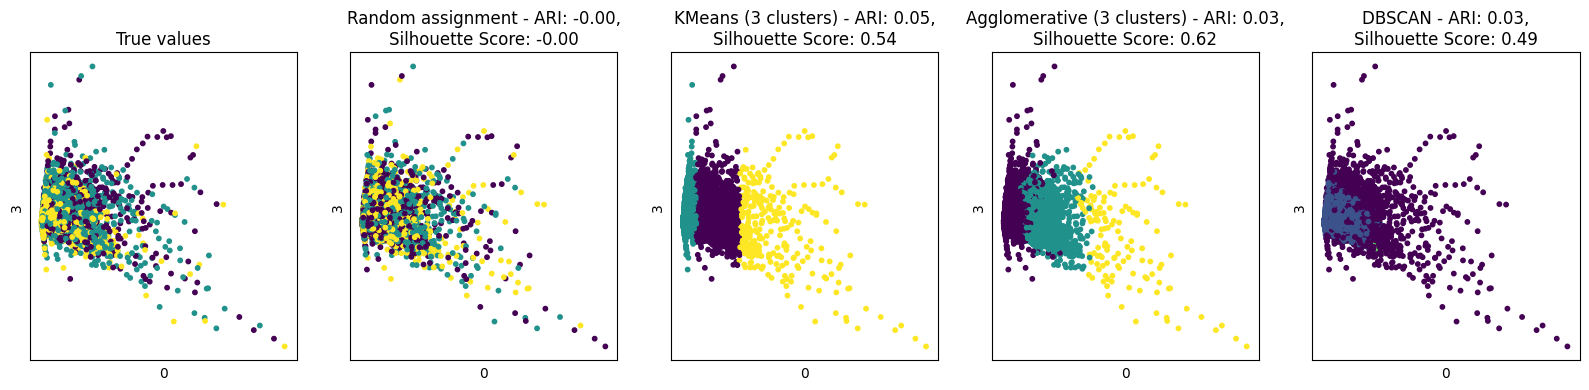

In [214]:
predictions = [{'alg': 'KMeans (3 clusters)', 'clusters':KMeans3_pca}, {'alg':'Agglomerative (3 clusters)', 'clusters':Agg3_pca}, {'alg':'DBSCAN', 'clusters':db_pca}]
plot_ARI(X_train_pca, y_train_small['readmitted'], predictions, 0, 3)

KMeans (2 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0               32824   3752
1                2203    660
Agglomerative (2 clusters) - clustering vs. target labels
readmit_less30  False  True 
row_0                       
0                1853    566
1               33174   3846
DBSCAN - clustering vs. target labels
readmit_less30  False  True 
row_0                       
-1               1632    554
 0              33370   3855
 1                  9      0
 2                 11      3
 3                  5      0


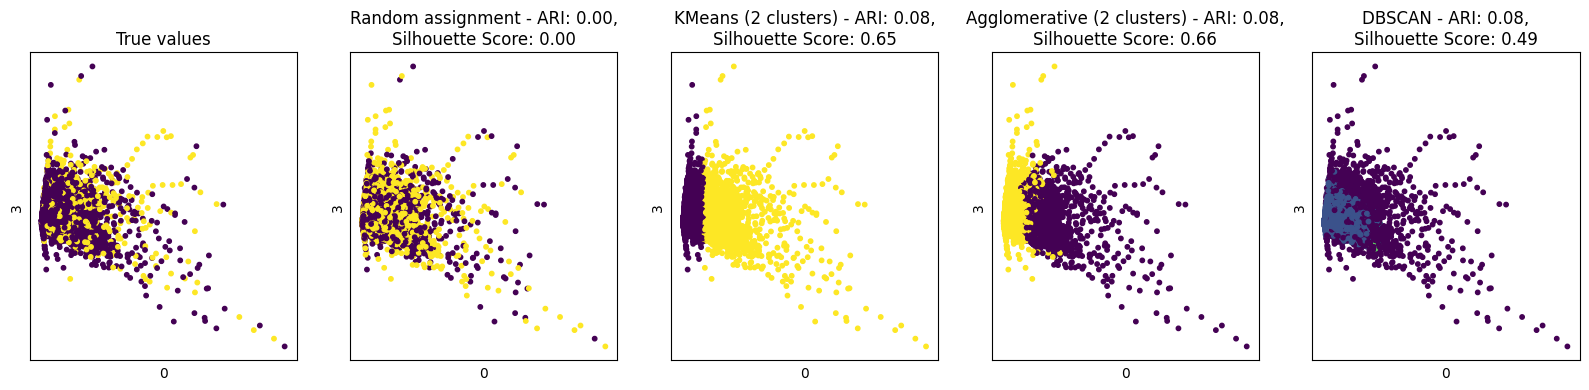

In [215]:
predictions = [{'alg': 'KMeans (2 clusters)', 'clusters':KMeans2_pca}, {'alg':'Agglomerative (2 clusters)', 'clusters':Agg2_pca}, {'alg':'DBSCAN', 'clusters':db_pca}]
plot_ARI(X_train_pca, y_train_small['readmit_less30'], predictions, 0, 3)